In [77]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score, average_precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import LabelEncoder

In [78]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_clustering.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [79]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")
print(lsoa_label.columns)

Index(['LSOA code', 'gentrified', 'gentri_clu', 'geometry'], dtype='object')


In [80]:
print(stru_data.columns)

Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [81]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [82]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [83]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [84]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [85]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate",  
                                          "avg_den", "senior_per", "minority_per",
                                          'all_dwelling', 'shared_per', 'converted_per',
                                          'level_4_pop', 'level_4_per',
                                          'prof_occ_count', 'prof_occ_per',
                                          'sale_avg',
                                          'single_per',
                                          'less_10km_per']], 
                                          how="left", predicate="within")

In [86]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [87]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "gentrified", 
                                                                            "pop_growth_rate", "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [88]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_383', 'geometry', 'centroid', 'index_right', 'LSOA code',
       'gentrified', 'pop_growth_rate', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=410)

In [89]:
# identify gentrification
joined_cleaned['gentrified'].value_counts()

gentrified
0.0    100880
1.0     54487
Name: count, dtype: int64

In [90]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

In [91]:
# gdf_lsoa: 是你读取的 LSOA 边界数据
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')

In [92]:
lsoa_label.isna().sum()

LSOA code              0
gentrified             0
gentri_clu             0
geometry               0
pop_growth_rate        0
avg_den                0
senior_per             0
minority_per           0
all_dwelling           0
shared_per             0
converted_per          0
level_4_pop            0
level_4_per            0
prof_occ_count         0
prof_occ_per           0
pro_sale_2019          0
sale_avg               0
single_per             0
less_10km_per          0
application_count    564
dtype: int64

In [93]:
lsoa_label['application_count'] = lsoa_label['application_count'].fillna(0).astype(int)

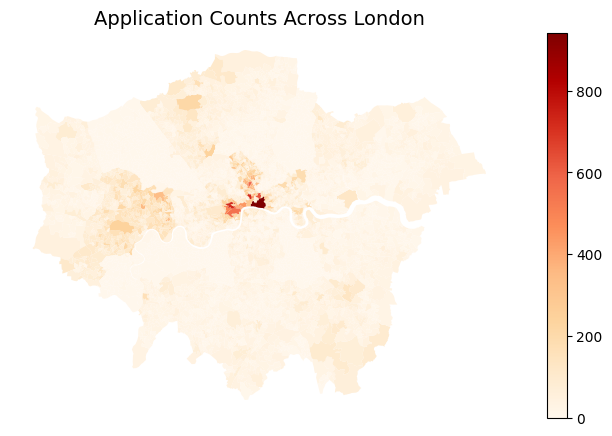

In [94]:
# 地图可视化
fig, ax = plt.subplots(figsize=(10, 5))
lsoa_label.plot(column='application_count', cmap='OrRd', legend=True, ax=ax)
ax.set_title("Application Counts Across London", fontsize=14)
ax.axis('off')
plt.show()

In [95]:
lsoa_scores = pd.read_csv("data/anchor_similarity_scores_mean_weighted_5.csv")

In [96]:
print(lsoa_scores.head(2))

   residential_mean  commercial_mean  green_mean  cultural_mean  \
0          1.268783         0.835534    0.808253       4.713725   
1          1.148539         0.805607    0.746763       4.257193   

   infrustructure_mean  LSOA code  
0             3.713691  E01000001  
1             3.839985  E01000002  


In [97]:
# 合并进 final_df
final_df = lsoa_scores.merge(lsoa_label, on="LSOA code", how="left")
final_df.fillna(0, inplace=True)
print(final_df.shape)

(4271, 25)


In [98]:
final_df.columns

Index(['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean',
       'infrustructure_mean', 'LSOA code', 'gentrified', 'gentri_clu',
       'geometry', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per', 'application_count'],
      dtype='object')

In [99]:
final_df['total_score'] = final_df[['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean']].sum(axis=1)

In [100]:
print(final_df[['LSOA code','total_score']].head(2))

   LSOA code  total_score
0  E01000001    11.339987
1  E01000002    10.798087


In [101]:
df_poi = pd.read_csv("data/poi_15_19.csv")
print(df_poi.head(5))

   LSOA code  shop_increase  metro_increase  bus_increase
0  E01000001            2.0            -1.0           1.0
1  E01000002            0.0             1.0          -6.0
2  E01000003            8.0             0.0           0.0
3  E01000005            6.0             1.0          -1.0
4  E01000006            0.0             0.0           0.0


In [102]:
final_df = final_df.merge(df_poi[['LSOA code','shop_increase','metro_increase','bus_increase']], on="LSOA code", how="left")

In [103]:
print(final_df.columns)
print(final_df.shape)

Index(['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean',
       'infrustructure_mean', 'LSOA code', 'gentrified', 'gentri_clu',
       'geometry', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per', 'application_count',
       'total_score', 'shop_increase', 'metro_increase', 'bus_increase'],
      dtype='object')
(4271, 29)


In [104]:
# 先确认你有个列表示是否gentri，比如叫 'gentri'
print(final_df['gentrified'].value_counts())
# 打印一个 gentri=0 的 LSOA 示例
print(final_df[final_df['gentrified'] == 0].sample(1, random_state=42))

gentrified
0    2859
1    1412
Name: count, dtype: int64
      residential_mean  commercial_mean  green_mean  cultural_mean  \
2110          1.999901         0.560391    0.891886        4.61368   

      infrustructure_mean  LSOA code  gentrified  gentri_clu  \
2110             4.198972  E01002366           0           5   

                                               geometry  pop_growth_rate  ...  \
2110  POLYGON ((552994.054 186421.191, 553155.003 18...              -12  ...   

      prof_occ_per  pro_sale_2019  sale_avg  single_per  less_10km_per  \
2110          11.7             64      75.0   21.126761      39.921977   

      application_count  total_score  shop_increase  metro_increase  \
2110                 14    12.264829            0.0             0.0   

      bus_increase  
2110           0.0  

[1 rows x 29 columns]


In [105]:
score_map = lsoa_label.merge(lsoa_scores, on="LSOA code", how="left")

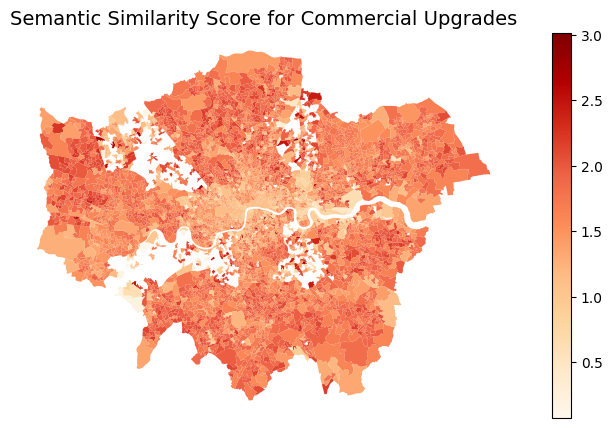

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
score_map.plot(column='residential_mean', 
               cmap='OrRd', 
               legend=True,
               ax=ax)
ax.set_title("Semantic Similarity Score for Commercial Upgrades", fontsize=14)
ax.axis('off')
plt.show()

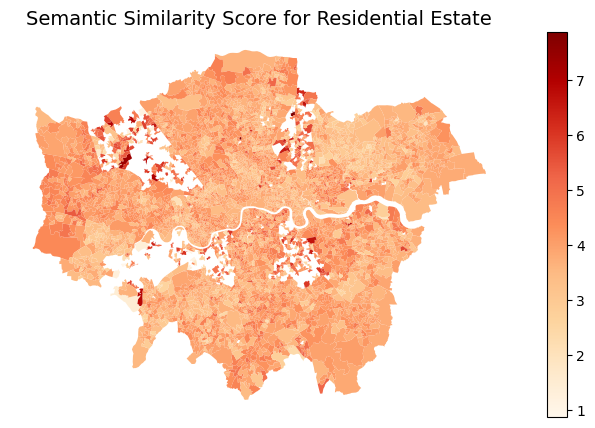

In [107]:
fig, ax = plt.subplots(figsize=(10, 5))
score_map.plot(column='infrustructure_mean', 
               cmap='OrRd', 
               legend=True,
               ax=ax)
ax.set_title("Semantic Similarity Score for Residential Estate", fontsize=14)
ax.axis('off')
plt.show()

In [108]:
import matplotlib.pyplot as plt

# 设置分类信息
categories = {
    "residential_mean": "Residential Estate",
    "infrustructure_mean": "Infrastructure Investment",
    "green_mean": "Green Space",
    "cultural_mean": "Cultural Change",
    "commercial_mean": "Commercial Upgrades"
}

# 创建 subplot 布局（2行3列，最后一个空着）
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

# 遍历绘制每一类
for i, (col, title) in enumerate(categories.items()):
    score_map.plot(column=col,
                   cmap='OrRd',
                   legend=True, 
                   ax=axes[i])
    axes[i].set_title(f"{title} Similarity Score", fontsize=12)
    axes[i].axis('off')

# 关闭最后一个空子图
axes[-1].axis('off')

plt.suptitle("Semantic Similarity Scores by Category", fontsize=16)
plt.tight_layout()
plt.show()

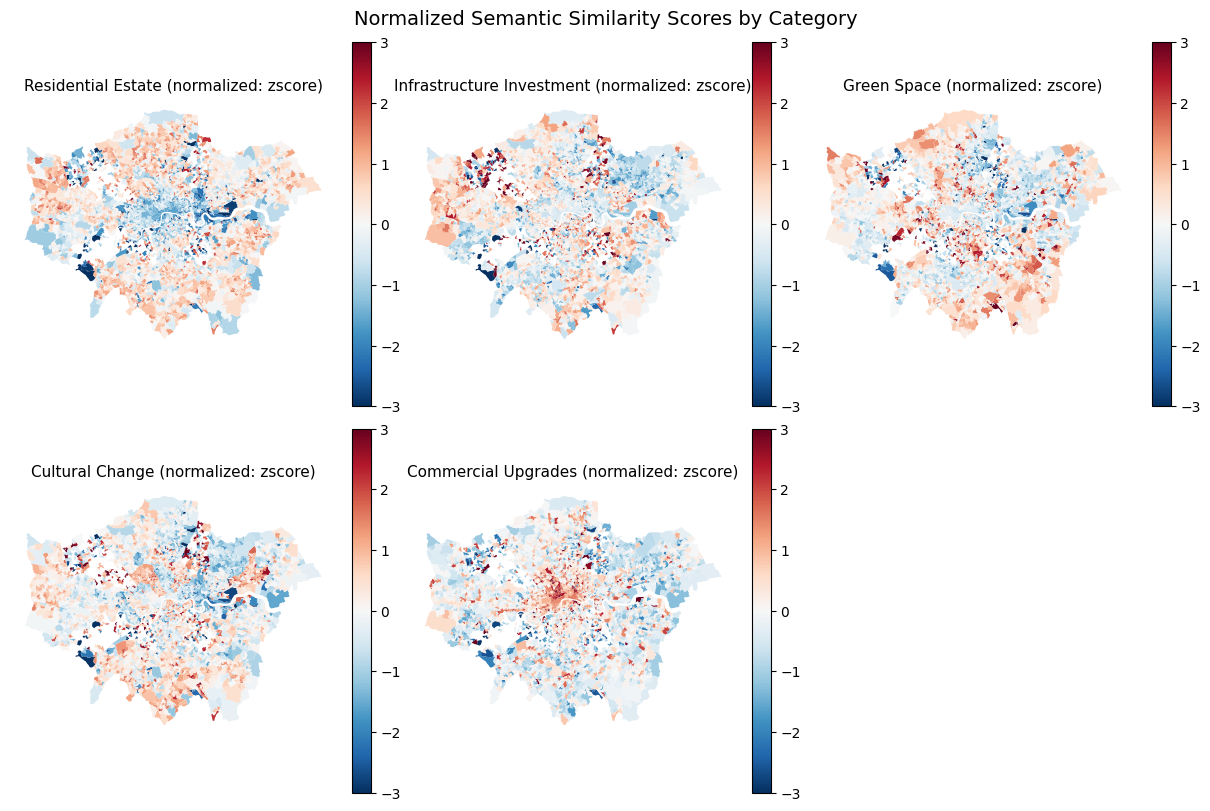

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm  # 只有在需要居中0时用
# GeoDataFrame: score_map ；每列是一个语义分数，几何列为 geometry

# 1) 定义要画的列（注意把拼写修正为 infrastructure_mean）
categories = {
    "residential_mean":     "Residential Estate",
    "infrustructure_mean":  "Infrastructure Investment",
    "green_mean":           "Green Space",
    "cultural_mean":        "Cultural Change",
    "commercial_mean":      "Commercial Upgrades"
}

# 2) 归一化函数：支持 z-score / minmax / percentile-rank
METHOD = "zscore"   # <-- "zscore" 或 "minmax"（或 "rank"）
CLIP_Z = 3.0        # z-score 可选截断范围，保证色标统一

def normalize_series(s, method="zscore"):
    x = s.astype(float).copy()
    if method == "zscore":
        mu, sd = np.nanmean(x), np.nanstd(x)
        z = (x - mu) / (sd if sd > 0 else 1.0)
        return z.clip(-CLIP_Z, CLIP_Z)
    elif method == "minmax":
        mn, mx = np.nanmin(x), np.nanmax(x)
        return (x - mn) / (mx - mn + 1e-12)
    elif method == "rank":
        return x.rank(pct=True)  # 0–1 的分位
    else:
        return x

# 3) 生成归一化后的列（加后缀 _norm）
for col in categories.keys():
    score_map[f"{col}_norm"] = normalize_series(score_map[col], METHOD)

# 4) 画图：2×3 面板（最后一个空着）
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()

# 统一色标（zscore 用对称色带；minmax 用 0–1）
if METHOD == "zscore":
    cmap = "RdBu_r"
    vmin, vmax = -CLIP_Z, CLIP_Z
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:  # minmax / rank
    cmap = "OrRd"
    vmin, vmax, norm = 0.0, 1.0, None

for i, (col, title) in enumerate(categories.items()):
    norm_col = f"{col}_norm"
    score_map.plot(
        column=norm_col,
        cmap=cmap,
        legend=True,
        ax=axes[i],
        vmin=vmin, vmax=vmax,
        norm=norm  # 对 zscore 会把 0 居中；minmax 时为 None
    )
    axes[i].set_title(f"{title} (normalized: {METHOD})", fontsize=11)
    axes[i].axis("off")

# 关掉最后一个空子图
axes[-1].axis("off")

fig.suptitle("Normalized Semantic Similarity Scores by Category", fontsize=14)
plt.show()

In [110]:
features = ['pop_growth_rate', 'avg_den', 'senior_per', 'sale_avg','shop_increase','bus_increase',
             'converted_per', 'single_per','minority_per',
            'residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean',
            'application_count','total_score']
base = ['pop_growth_rate', 'avg_den', 'senior_per','sale_avg',
        'shop_increase','bus_increase',
         'converted_per', 'single_per','minority_per']
features_text = ['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean', 'application_count','total_score']

C:\Users\hp\AppData\Local\Temp\ipykernel_14712\2755802247.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\2755802247.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\2755802247.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\2755802247.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `leg

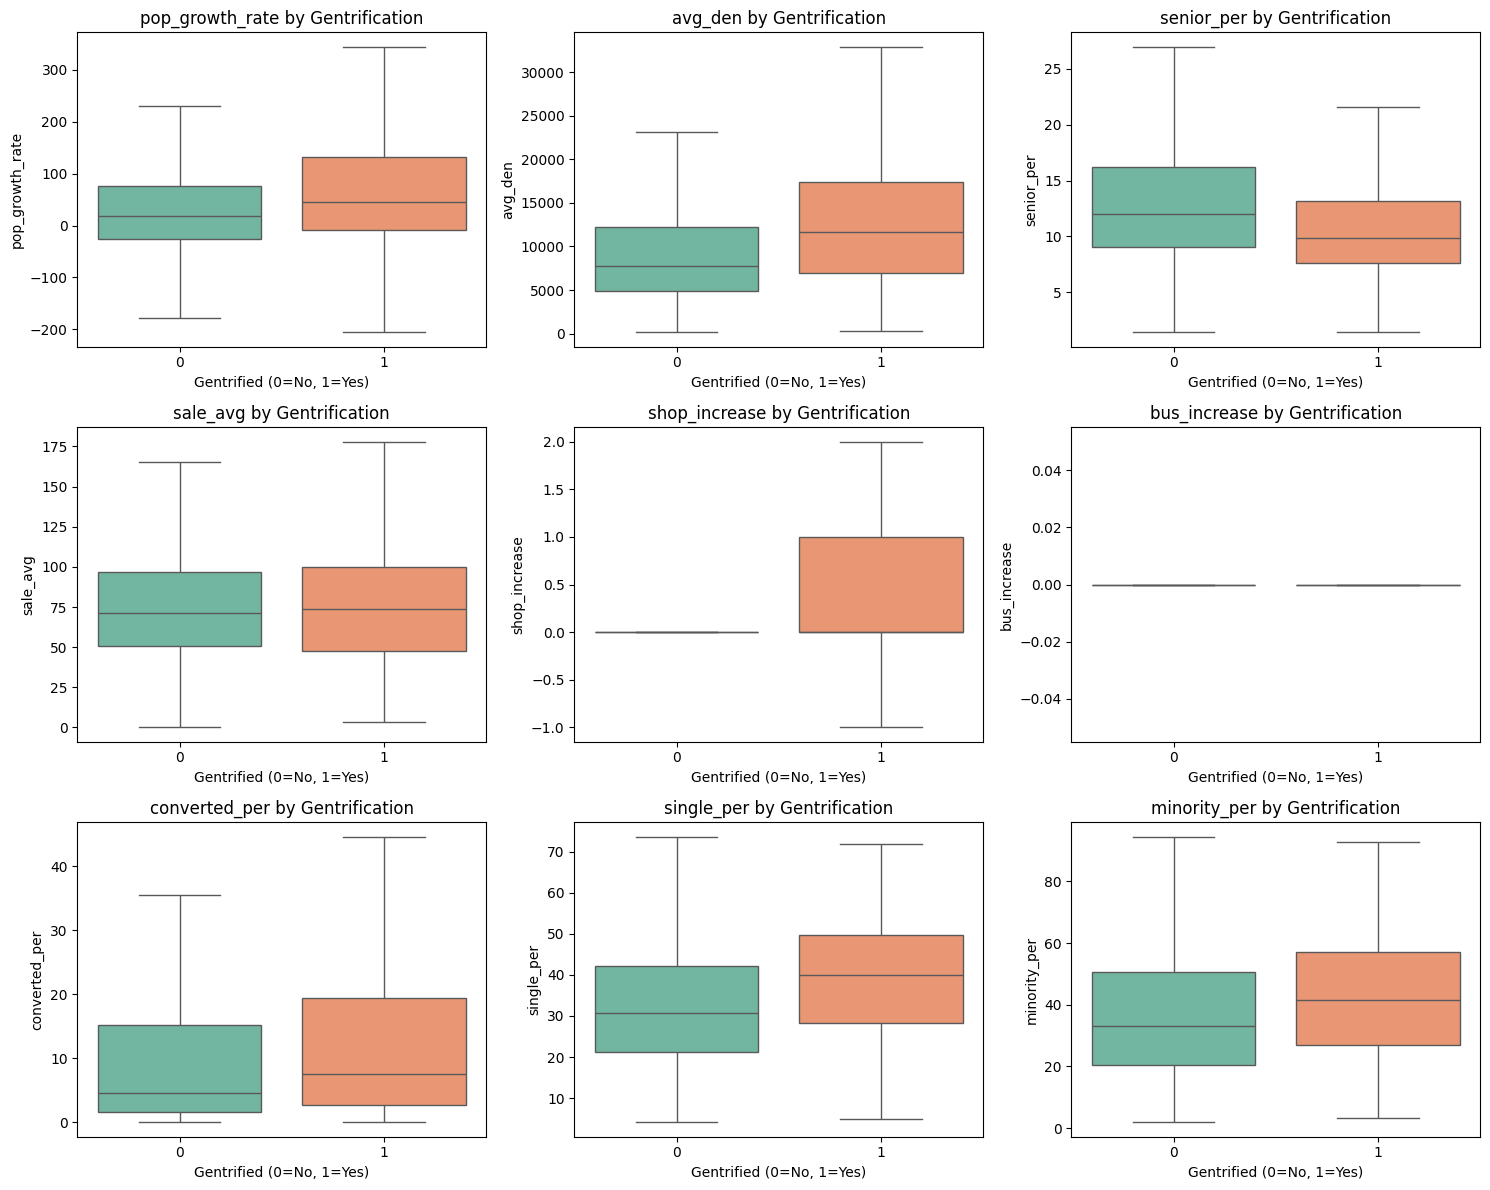

In [111]:
# 开始绘图
n_cols = 3  # 每行显示几个图
n_rows = -(-len(base) // n_cols)  # 自动计算行数（向上取整）

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(base):
    sns.boxplot(
        data=final_df,
        x='gentrified',
        y=feature,
        ax=axes[i],
        palette='Set2',
        showfliers=False  # 不显示离群点，图更清晰
    )
    axes[i].set_title(f'{feature} by Gentrification')
    axes[i].set_xlabel('Gentrified (0=No, 1=Yes)')
    axes[i].set_ylabel(feature)

# 去掉多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

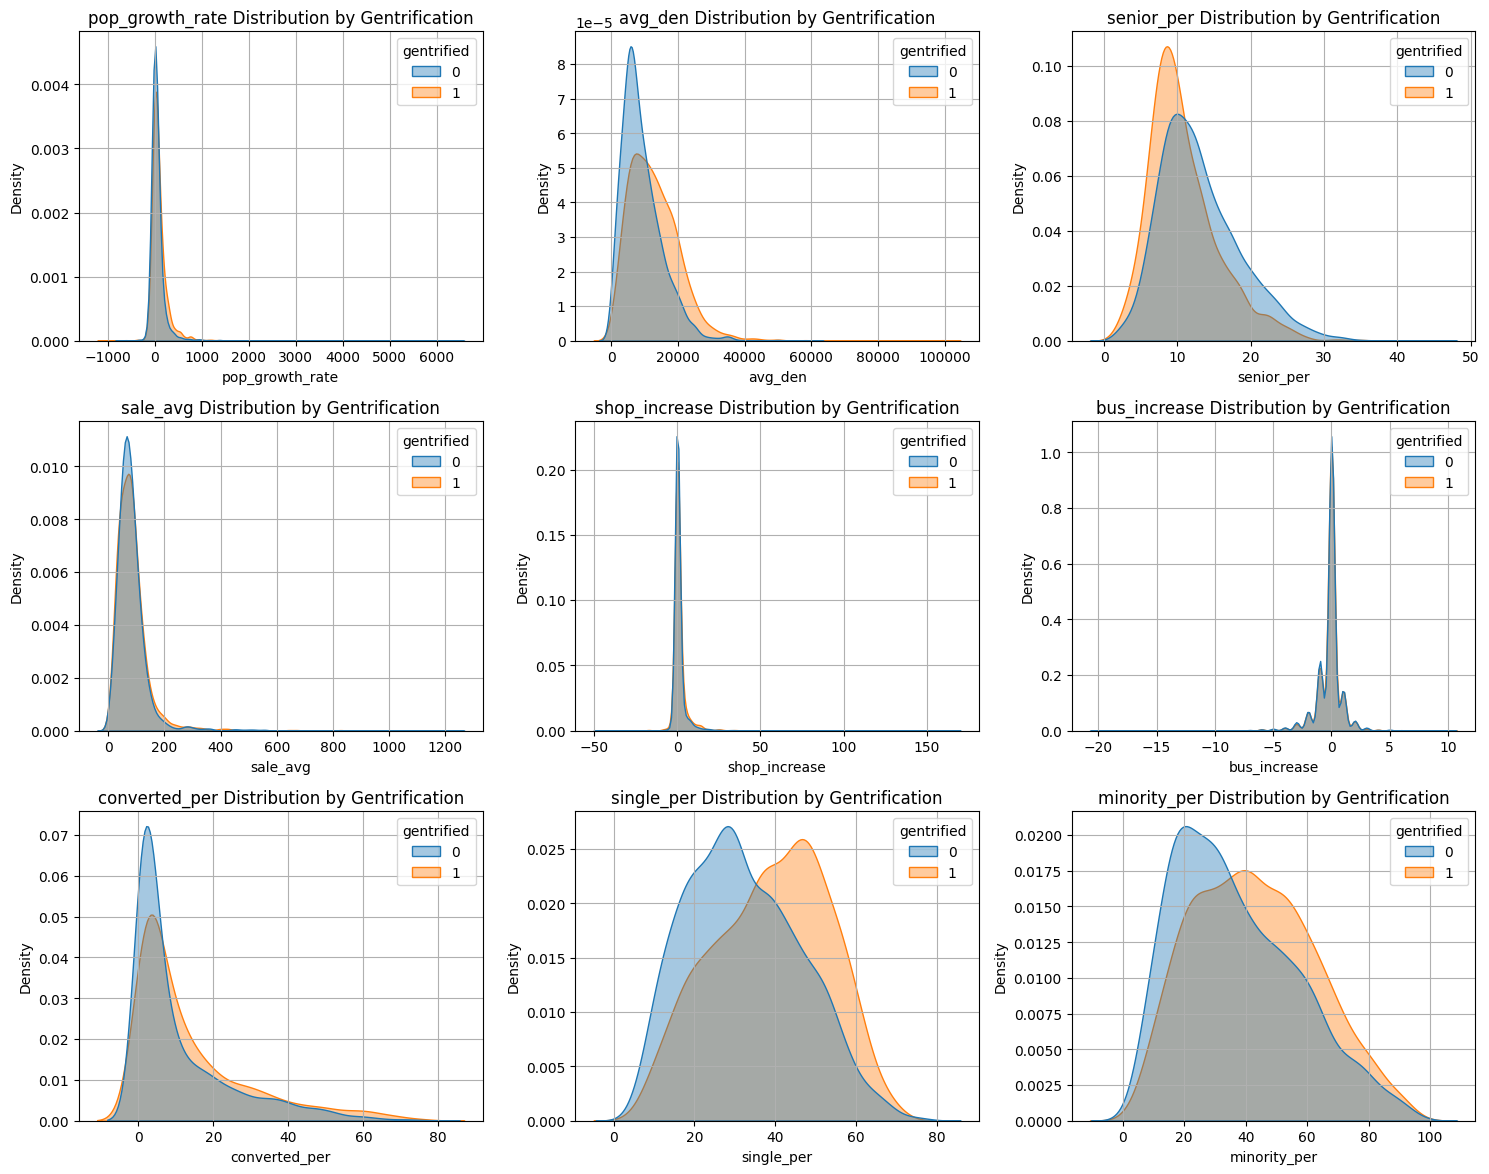

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 设定你要画 KDE 的特征列表
# base = ['feature1', 'feature2', ...]  # ← 你已有的变量名列表
# 假设你已有 base 列表：
# base = ['avg_den', 'sale_avg', 'converted_per', ...] 

n_cols = 3
n_rows = math.ceil(len(base) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(base):
    sns.kdeplot(
        data=final_df,
        x=feature,
        hue='gentrified',
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=axes[i]
    )
    axes[i].set_title(f'{feature} Distribution by Gentrification')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

# 去掉多余子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


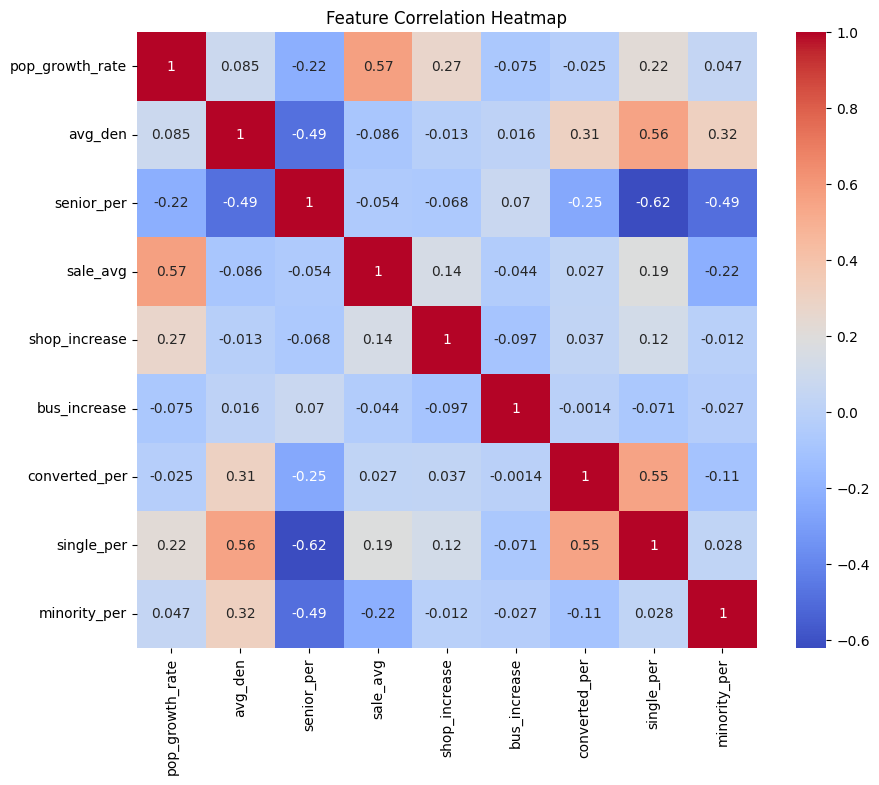

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(final_df[base].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [154]:
features = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
            'all_dwelling','converted_per', 
            'prof_occ_count',
            'sale_avg',
            'single_per',
            'shop_increase','bus_increase',
            'residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean',
            'application_count','total_score']
base = ['pop_growth_rate', 'avg_den', 'senior_per','sale_avg',
        'shop_increase','bus_increase',
        'single_per','minority_per']
features_text = ['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean', 'application_count','total_score']

In [155]:
# 特征和标签
X = final_df[features]
y = final_df['gentrified'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# 计算样本数
true_count = final_df['gentrified'].sum()
false_count = len(final_df) - true_count
scale_pos_weight = false_count / true_count


# 模型训练
model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# 预测 & 评估
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, average_precision_score
y_proba = model.predict_proba(X_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_test, y_proba))
print("AUPRC:", average_precision_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       715
           1       0.53      0.44      0.48       353

    accuracy                           0.69      1068
   macro avg       0.64      0.62      0.63      1068
weighted avg       0.67      0.69      0.68      1068

AUROC: 0.6556270924542879
AUPRC: 0.4913023756902315


### Logistic

[Fold 1] th=0.493 | ACC=0.6253 AUC=0.6671 F1=0.5340 REC=0.6497 PR-AUC=0.4844 G-mean=0.6312
[Fold 2] th=0.465 | ACC=0.6105 AUC=0.6932 F1=0.5521 REC=0.7261 PR-AUC=0.5229 G-mean=0.6339
[Fold 3] th=0.512 | ACC=0.6295 AUC=0.6524 F1=0.5056 REC=0.5732 PR-AUC=0.4942 G-mean=0.6138
[Fold 4] th=0.494 | ACC=0.6232 AUC=0.6594 F1=0.5175 REC=0.6115 PR-AUC=0.5115 G-mean=0.6201
[Fold 5] th=0.503 | ACC=0.6547 AUC=0.6875 F1=0.5638 REC=0.6752 PR-AUC=0.5190 G-mean=0.6597
[Fold 6] th=0.474 | ACC=0.6118 AUC=0.6710 F1=0.5377 REC=0.6859 PR-AUC=0.5342 G-mean=0.6283
[Fold 7] th=0.427 | ACC=0.5464 AUC=0.6812 F1=0.5233 REC=0.7516 PR-AUC=0.4899 G-mean=0.5782
[Fold 8] th=0.450 | ACC=0.5970 AUC=0.6658 F1=0.5398 REC=0.7134 PR-AUC=0.4805 G-mean=0.6203
[Fold 9] th=0.545 | ACC=0.6962 AUC=0.7177 F1=0.5556 REC=0.5732 PR-AUC=0.5820 G-mean=0.6588

===== Logistic Regression (9-fold CV) Summary =====
Average Accuracy:   0.6216
Average AUROC:      0.6773
Average Log-loss:   0.6449
Average G-mean:     0.6272
Average F1-score:   

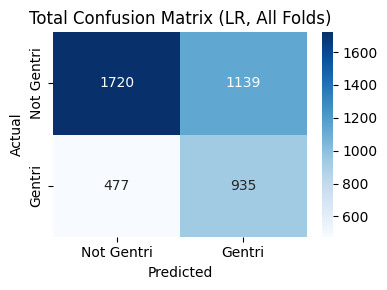

In [116]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss, f1_score, recall_score,
    average_precision_score, precision_recall_curve, confusion_matrix
)
from imblearn.metrics import geometric_mean_score

# ====== 配置 ======
# 用于每个外层折里是否做一次内部分割来“调阈值”（按验证集 F1 最大化）
TUNE_THRESHOLD = True
VAL_SIZE = 0.2           # 内部分割验证集占比
RANDOM_STATE = 42

# ====== 特征与标签 ======
# 你已有：final_df, features
X = final_df[features]
y = final_df['gentrified'].astype(int)

# ====== 评估器初始化 ======
kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=RANDOM_STATE)
acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls, auc_prs = [], [], [], [], [], [], []

# 混淆矩阵总计
total_cm = np.array([[0, 0], [0, 0]], dtype=int)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- 建立标准化 + 逻辑回归管道 ---
    # class_weight='balanced' 处理类别不平衡；saga 支持大多数惩罚形式，收敛更稳，max_iter 拉高避免告警
    lr = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(
            penalty="l2",          # 也可改为 'elasticnet' 并配合 l1_ratio
            C=1.0,
            solver="saga",
            max_iter=5000,
            n_jobs=-1,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ])

    # --- 可选：内部分割调阈值（在每个外层折的训练集上完成，不用测试集信息） ---
    best_threshold = 0.5
    if TUNE_THRESHOLD:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE + fold)
        inner_train_idx, inner_val_idx = next(sss.split(X_train, y_train))
        X_tr, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
        y_tr, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

        lr.fit(X_tr, y_tr)
        val_proba = lr.predict_proba(X_val)[:, 1]

        # 用 PR 曲线上的阈值网格寻找 F1 最大点
        precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
        # PR 曲线返回的 thresholds 长度比 precision/recall 少 1，需要对齐
        f1_vals = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
        if len(f1_vals) > 0:
            best_idx = np.argmax(f1_vals)
            best_threshold = thresholds[best_idx]

        # 用全部外层训练数据重拟合
        lr.fit(X_train, y_train)
    else:
        lr.fit(X_train, y_train)

    # --- 测试集评估 ---
    y_proba = lr.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_proba)

    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)
    gmean_scores.append(gmean)
    f1s.append(f1)
    recalls.append(recall)
    auc_prs.append(auc_pr)

    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    total_cm += cm

    print(f"[Fold {fold}] th={best_threshold:.3f} | ACC={acc:.4f} AUC={auc:.4f} F1={f1:.4f} REC={recall:.4f} PR-AUC={auc_pr:.4f} G-mean={gmean:.4f}")

# ====== 汇总平均结果 ======
print("\n===== Logistic Regression (9-fold CV) Summary =====")
print(f"Average Accuracy:   {np.mean(acc_scores):.4f}")
print(f"Average AUROC:      {np.mean(auc_scores):.4f}")
print(f"Average Log-loss:   {np.mean(logloss_scores):.4f}")
print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")
print(f"Average AUC-PR:     {np.mean(auc_prs):.4f}")

# ====== 总混淆矩阵 ======
print("\n===== Total Confusion Matrix across all folds =====")
print(total_cm)

# 可选：可视化
plt.figure(figsize=(4, 3))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Gentri', 'Gentri'],
            yticklabels=['Not Gentri', 'Gentri'])
plt.title('Total Confusion Matrix (LR, All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



===== Cross-Validation Summary =====
Average Accuracy:   0.6727
Average AUROC:      0.6649
Average Log-loss:   0.7036
Average G-mean:     0.5954
Average F1-score:   0.4787
Average Recall:     0.4546
Average AUC-PR:     0.5100

===== Total Confusion Matrix across all folds =====
[[2231  628]
 [ 770  642]]


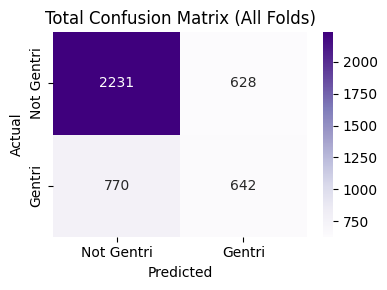

In [156]:
# 特征和标签
X = final_df[features]
y = final_df['gentrified'].astype(int)

# 初始化评估器
kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls, auc_prs = [], [], [], [], [], [], []

# 混淆矩阵总计
total_cm = np.array([[0, 0], [0, 0]])

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 自动设置 scale_pos_weight
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    model = XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
    )

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.5
    y_pred = (y_proba >= threshold).astype(int)

    # 评估
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_proba)

    # 记录评估分数
    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)
    gmean_scores.append(gmean)
    f1s.append(f1)
    recalls.append(recall)
    auc_prs.append(auc_pr)

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm

# 汇总平均结果
print("\n===== Cross-Validation Summary =====")
print(f"Average Accuracy:   {np.mean(acc_scores):.4f}")
print(f"Average AUROC:      {np.mean(auc_scores):.4f}")
print(f"Average Log-loss:   {np.mean(logloss_scores):.4f}")
print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")
print(f"Average AUC-PR:     {np.mean(auc_prs):.4f}")

# 打印总混淆矩阵
print("\n===== Total Confusion Matrix across all folds =====")
print(total_cm)

# 可选：总混淆矩阵可视化
plt.figure(figsize=(4, 3))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Gentri', 'Gentri'],
            yticklabels=['Not Gentri', 'Gentri'])
plt.title('Total Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

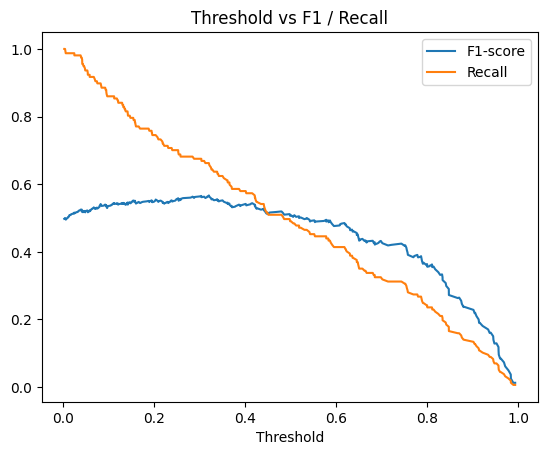

In [118]:
from sklearn.metrics import precision_recall_curve

prec, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * recall) / (prec + recall)

plt.plot(thresholds, f1[:-1], label='F1-score')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Threshold vs F1 / Recall")
plt.show()

### 下采样


===== Cross-Validation Summary (With Random Undersampling) =====
Average Accuracy:   0.6322
Average AUROC:      0.6729
Average Log-loss:   0.7748
Average G-mean:     0.6288
Average F1-score:   0.5272
Average Recall:     0.6197
Average AUC-PR:     0.5158


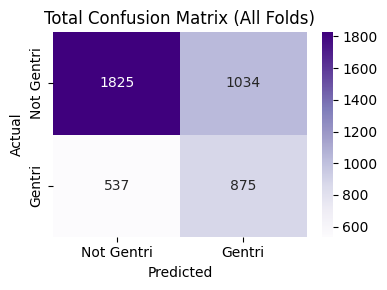

In [157]:
from imblearn.under_sampling import RandomUnderSampler
X = final_df[features]
y = final_df['gentrified']

# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
#                                                                                             stratify=y_resampled, 
#                                                                                             test_size=0.25, 
#                                                                                             random_state=42)

# scale_pos_weight = len(y_resampled_train[y_resampled_train == 0]) / len(y_resampled_train[y_resampled_train == 1])

# model_resampled = XGBClassifier(scale_pos_weight = scale_pos_weight,
#                       random_state=42, 
#                       eval_metric="aucpr")

# model_resampled.fit(X_resampled_train, y_resampled_train)

# # Evaluate
# y_resampled_pred = model_resampled.predict(X_resampled_test)
# print(classification_report(y_resampled_test, y_resampled_pred))
# y_resampled_proba = model_resampled.predict_proba(X_resampled_test)[:, 1]  # 取预测为 1 的概率
# print("AUROC:", roc_auc_score(y_resampled_test, y_resampled_proba))
# print("AUPRC:", average_precision_score(y_resampled_test, y_resampled_proba))
# print("F1 Score:", f1_score(y_resampled_test, y_resampled_pred))
# print("Recall:", recall_score(y_resampled_test, y_resampled_pred))
# print("Accuracy:", accuracy_score(y_resampled_test, y_resampled_pred))

# 初始化评估器
kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls, auc_prs = [], [], [], [], [], [], []

# 混淆矩阵总计
total_cm = np.array([[0, 0], [0, 0]])

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ✅ 添加：下采样（只对训练集）
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    model = XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
    )

    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # 评估
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_proba)

    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)
    gmean_scores.append(gmean)
    f1s.append(f1)
    recalls.append(recall)
    auc_prs.append(auc_pr)

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm

# 汇总平均结果
print("\n===== Cross-Validation Summary (With Random Undersampling) =====")
print(f"Average Accuracy:   {np.mean(acc_scores):.4f}")
print(f"Average AUROC:      {np.mean(auc_scores):.4f}")
print(f"Average Log-loss:   {np.mean(logloss_scores):.4f}")
print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")
print(f"Average AUC-PR:     {np.mean(auc_prs):.4f}")

# 混淆矩阵可视化
plt.figure(figsize=(4, 3))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Gentri', 'Gentri'],
            yticklabels=['Not Gentri', 'Gentri'])
plt.title('Total Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


### 超参调优后的结果

In [120]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # 1) 在 trial 中定义搜索空间
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth':    trial.suggest_int('max_depth', 3, 10),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'subsample':    trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma':        trial.suggest_loguniform('gamma', 1e-3, 10.0),
        'reg_alpha':    trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda':   trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'scale_pos_weight': (len(y)-y.sum())/y.sum(),
        'objective':    'binary:logistic',
        'eval_metric':  'auc',
        'use_label_encoder': False,
        'random_state': 42
    }
    model = XGBClassifier(**params)

    # 2) 用 cross_val_score 计算 f1
    scores = cross_val_score(
        model, X, y,
        cv=StratifiedKFold(9, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=1
    )
    return scores.mean()

# 3) 创建并运行 Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

# 4) 打印最优结果
print("Best f1:", study.best_value)
print("Best params:", study.best_trial.params)

# 5) 用最优参数训练最终模型
best_params = study.best_trial.params
best_params.update({
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'use_label_encoder':False,
    'random_state':42
})
best_model = XGBClassifier(**best_params)
best_model.fit(X, y)

[I 2025-08-12 10:49:34,391] A new study created in memory with name: no-name-e8bf1c78-387a-47c7-a3df-541c032066fa
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\3625869223.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\3625869223.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':    trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\hp\AppData\Local\Temp\ipykernel_14712\3625869223.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Best f1: 0.5549017310169694
Best params: {'n_estimators': 353, 'max_depth': 7, 'learning_rate': 0.007567194332078063, 'subsample': 0.8765163315995839, 'colsample_bytree': 0.7064841322601808, 'min_child_weight': 7, 'gamma': 0.037298081864098435, 'reg_alpha': 4.286914373233896, 'reg_lambda': 0.19230844322120264}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7064841322601808, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.037298081864098435, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.007567194332078063, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=353, n_jobs=None,
              num_parallel_tree=None, ...)

In [121]:
import joblib

# 保存模型
joblib.dump(best_model, "xgb_model_best2.pkl")

['xgb_model_best2.pkl']

e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:2


===== Cross-Validation Summary =====
Average Accuracy:   0.6415
Average AUROC:      0.7071
Average Log-loss:   0.5722
Average G-mean:     0.6516
Average F1-score:   0.5718
Average Recall:     0.7203
Average AUC-PR:     0.5683


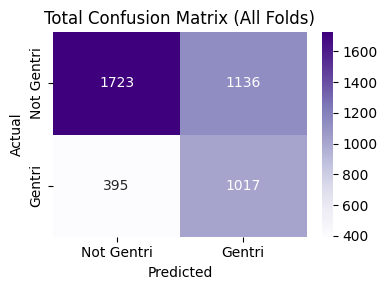

In [158]:
X2 = final_df[features]
y2 = final_df['gentrified'].astype(int)

kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls, auc_prs = [], [], [], [], [], [], []
total_cm = np.array([[0, 0], [0, 0]])

for fold, (train_idx, test_idx) in enumerate(kf.split(X2, y2), 1):
    X_tr, X_va = X2.iloc[train_idx], X2.iloc[test_idx]
    y_tr, y_va = y2.iloc[train_idx], y2.iloc[test_idx]

    # ✔ 每个折单独计算类权重
    spw = (len(y_tr) - y_tr.sum()) / max(1, y_tr.sum())

    # ✔ 正确地把参数“展开”传入模型，而不是用 params={}
    clf = XGBClassifier(
        **best_params
    )

    # ✔ 加上早停（可让 n_estimators 实际更合理）
    clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    proba = clf.predict_proba(X_va)[:, 1]

    # ✔ 用 PR 曲线在该折上找“F1 最优阈值”，而不是固定 0.5
    prec, rec, ths = precision_recall_curve(y_va, proba)
    f1_curve = 2 * prec * rec / (prec + rec + 1e-12)
    best_idx = f1_curve.argmax()
    thr = ths[max(best_idx-1, 0)]

    y_pred = (proba >= thr).astype(int)

    # 指标
    acc_scores.append(accuracy_score(y_va, y_pred))
    auc_scores.append(roc_auc_score(y_va, proba))
    logloss_scores.append(log_loss(y_va, proba))
    try:
        from imblearn.metrics import geometric_mean_score
        gmean_scores.append(geometric_mean_score(y_va, y_pred))
    except Exception:
        pass
    f1s.append(f1_score(y_va, y_pred, zero_division=0))
    recalls.append(recall_score(y_va, y_pred))
    auc_prs.append(average_precision_score(y_va, proba))

    total_cm += confusion_matrix(y_va, y_pred)

print("\n===== Cross-Validation Summary =====")
print(f"Average Accuracy:   {np.mean(acc_scores):.4f}")
print(f"Average AUROC:      {np.mean(auc_scores):.4f}")
print(f"Average Log-loss:   {np.mean(logloss_scores):.4f}")
if gmean_scores: 
    print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")
print(f"Average AUC-PR:     {np.mean(auc_prs):.4f}")


plt.figure(figsize=(4, 3))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Gentri', 'Gentri'],
            yticklabels=['Not Gentri', 'Gentri'])
plt.title('Total Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:5

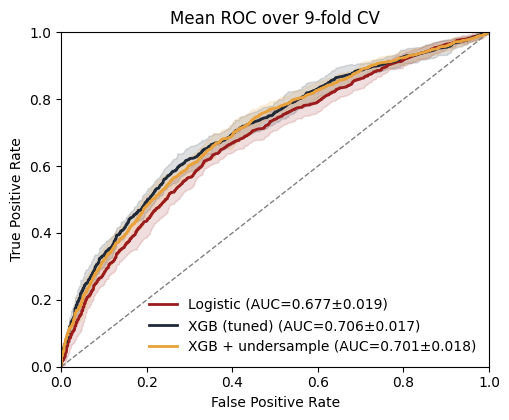

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from imblearn.pipeline import Pipeline as ImbPipeline


# ===== 你已有的数据 =====
X = final_df[features]
y = final_df['gentrified'].astype(int)
kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

# ===== 平均 ROC / PR 曲线工具 =====
def plot_cv_roc(estimator, X, y, kf, label, color):
    mean_fpr = np.linspace(0, 1, 1001)
    tprs, aucs = [], []
    for tr_idx, te_idx in kf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        est = clone(estimator).fit(X_tr, y_tr)
        proba = est.predict_proba(X_te)[:, 1]
        fpr, tpr, _ = roc_curve(y_te, proba)
        aucs.append(roc_auc_score(y_te, proba))
        tpr_i = np.interp(mean_fpr, fpr, tpr); tpr_i[0] = 0.0
        tprs.append(tpr_i)
    mean_tpr = np.mean(tprs, axis=0); mean_tpr[-1] = 1.0
    std_tpr  = np.std(tprs, axis=0)
    plt.plot(mean_fpr, mean_tpr, lw=2, color=color,
             label=f"{label} (AUC={np.mean(aucs):.3f}±{np.std(aucs):.3f})")
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr,0), np.minimum(mean_tpr+std_tpr,1),
                     color=color, alpha=0.15)

def plot_cv_pr(estimator, X, y, kf, label, color):
    mean_recall = np.linspace(0, 1, 1001)
    precisions, aps = [], []
    for tr_idx, te_idx in kf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        est = clone(estimator).fit(X_tr, y_tr)
        proba = est.predict_proba(X_te)[:, 1]
        prec, rec, _ = precision_recall_curve(y_te, proba)
        aps.append(average_precision_score(y_te, proba))
        # 反转保证单调，再插值到统一 recall 网格
        precisions.append(np.interp(mean_recall, rec[::-1], prec[::-1]))
    mean_prec = np.mean(precisions, axis=0)
    std_prec  = np.std(precisions, axis=0)
    plt.plot(mean_recall, mean_prec, lw=2, color=color,
             label=f"{label} (AP={np.mean(aps):.3f}±{np.std(aps):.3f})")
    plt.fill_between(mean_recall, np.maximum(mean_prec-std_prec,0), np.minimum(mean_prec+std_prec,1),
                     color=color, alpha=0.15)

# ===== 三个模型 =====
# 1) Logistic baseline
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1, solver="saga"))
])

# 2) Tuned XGB（用你的 best_params）
xgb_tuned = XGBClassifier(**best_params)

# 3) RandomUnderSampler + XGB
#    注意：避免“双重平衡”——如果 best_params 里有 scale_pos_weight，建议在下采样版本里把它设为 1
best_params_us = dict(best_params)
best_params_us["scale_pos_weight"] = 1.0
xgb_under = ImbPipeline([
    ("under", RandomUnderSampler(random_state=42)),
    ("clf", XGBClassifier(**best_params_us))
])

# ===== 画 ROC =====
plt.figure(figsize=(5.2,4.3))
plt.plot([0,1],[0,1],"--",color="gray",lw=1)
plot_cv_roc(lr,         X, y, kf, label="Logistic",          color="#9b1c1c")
plot_cv_roc(xgb_tuned,  X, y, kf, label="XGB (tuned)",       color="#1f2937")
plot_cv_roc(xgb_under,  X, y, kf, label="XGB + undersample", color="#e9a23b")
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Mean ROC over 9-fold CV")
plt.legend(frameon=False); plt.tight_layout(); plt.show()


In [124]:
# 先画三条模型的 PR
plt.figure(figsize=(5.2,4.3))
plot_cv_pr(lr,         X, y, kf, label="Logistic",          color="#9b1c1c")
plot_cv_pr(xgb_tuned,  X, y, kf, label="XGB (tuned)",       color="#1f2937")
plot_cv_pr(xgb_under,  X, y, kf, label="XGB + undersample", color="#e9a23b")

# === 加 PR 基线（no-skill）===
pis = []
for tr_idx, te_idx in kf.split(X, y):
    pis.append(y.iloc[te_idx].mean())       # 每个测试折的正例占比
pi_mean = float(np.mean(pis))
pi_std  = float(np.std(pis))

# 水平线 + （可选）±1σ 阴影带
plt.axhline(pi_mean, ls="--", color="gray",
            label=f"No-skill (AP={pi_mean:.3f}±{pi_std:.3f})")
xs = np.linspace(0, 1, 100)
low = np.clip(pi_mean - pi_std, 0, 1)
high = np.clip(pi_mean + pi_std, 0, 1)
plt.fill_between(xs, low, high, color="gray", alpha=0.10)

# 其它修饰
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Mean PR over 9-fold CV")
plt.legend(frameon=False); plt.tight_layout(); plt.show()

e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:0

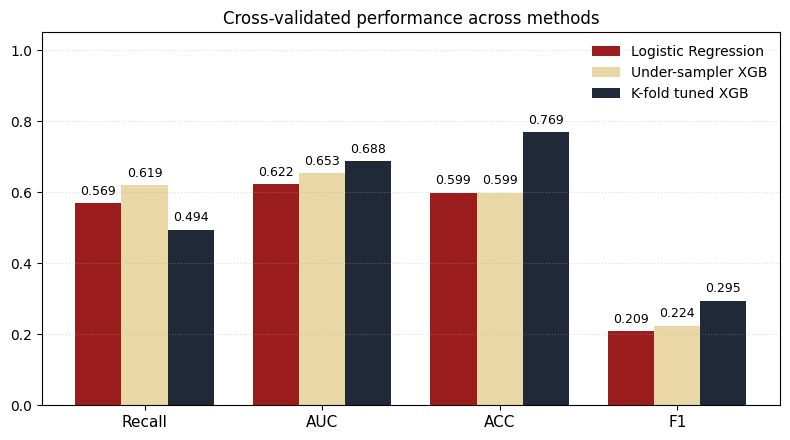

In [125]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 你的平均结果（注意第三个我帮你改回 res_tuned_k_fold_xgb）
res_lr = {"ACC": 0.5987, "F1": 0.2086, "AUC": 0.6221, "Recall": 0.5685}
res_under_sampler_xgb = {"ACC": 0.5989, "F1": 0.2242, "AUC": 0.6534, "Recall": 0.6190}
res_tuned_k_fold_xgb  = {"ACC": 0.7693, "F1": 0.2949, "AUC": 0.6877, "Recall": 0.4940}

# 组装为 DataFrame（每行=一个方法）
df = pd.DataFrame([
    {**res_lr, "Method": "Logistic Regression"},
    {**res_under_sampler_xgb, "Method": "Under-sampler XGB"},
    {**res_tuned_k_fold_xgb,  "Method": "K-fold tuned XGB"},
])

# 想展示的指标顺序（可改成你需要的，比如 Recall/AUC/ACC/F1）
metrics_order = ["Recall", "AUC", "ACC", "F1"]
methods_order = ["Logistic Regression", "Under-sampler XGB", "K-fold tuned XGB"]
colors = ["#9b1c1c", "#e9d8a6", "#1f2937"]  # 深红/米色/深灰，类似你图的三类

# 转成长表更方便绘图
df_long = df.melt(id_vars="Method", var_name="Metric", value_name="Score")
df_long["Metric"] = pd.Categorical(df_long["Metric"], categories=metrics_order, ordered=True)
df_long["Method"] = pd.Categorical(df_long["Method"], categories=methods_order, ordered=True)
df_long = df_long.sort_values(["Metric","Method"])

# 分组柱状图
fig, ax = plt.subplots(figsize=(8, 4.5))
x = np.arange(len(metrics_order))         # 指标组的位置
width = 0.26                              # 每个柱子的宽度

for i, method in enumerate(methods_order):
    vals = df_long[df_long["Method"] == method]["Score"].values
    ax.bar(x + (i-1)*width, vals, width=width, label=method, color=colors[i])
    # 在柱子顶部标数值
    for xi, v in zip(x + (i-1)*width, vals):
        ax.text(xi, v + 0.015, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(metrics_order, fontsize=11)
ax.set_ylim(0, 1.05)
ax.set_title("Cross-validated performance across methods", fontsize=12)
ax.legend(frameon=False)
ax.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()


e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:3

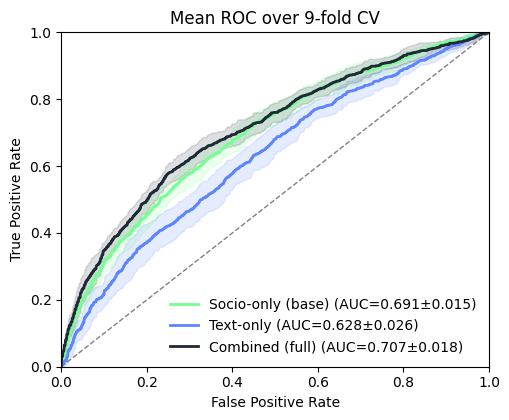

e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:4

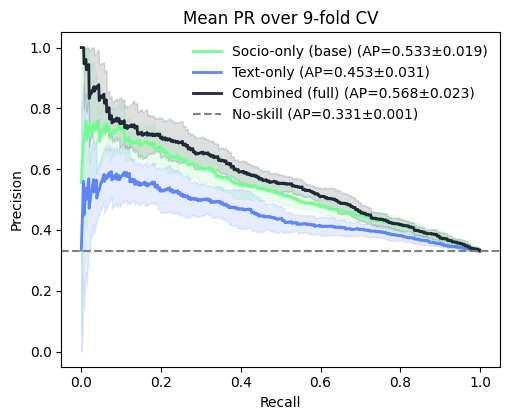

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
# 如果想换成逻辑回归：
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# ===== 你的数据与三套特征 =====
y = final_df["gentrified"].astype(int)
X_base = final_df[base]      # e.g. 13 socio vars
X_text = final_df[features_text]      # e.g. 5 semantic scores
X_full = final_df[features]      # 18 combined

kf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

# 选模型：用你调好的 XGB 参数（或换成 LR 管道）
estimator = XGBClassifier(**best_params)
# estimator = Pipeline([("scaler", StandardScaler()),
#                       ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1, solver="saga"))])

def mean_roc_curve(estimator, X, y, kf):
    mean_fpr = np.linspace(0, 1, 1001)
    tprs, aucs = [], []
    for tr, te in kf.split(X, y):
        est = clone(estimator).fit(X.iloc[tr], y.iloc[tr])
        proba = est.predict_proba(X.iloc[te])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[te], proba)
        aucs.append(roc_auc_score(y.iloc[te], proba))
        tpr_i = np.interp(mean_fpr, fpr, tpr); tpr_i[0] = 0.0
        tprs.append(tpr_i)
    mean_tpr = np.mean(tprs, axis=0); mean_tpr[-1] = 1.0
    std_tpr  = np.std(tprs, axis=0)
    return mean_fpr, mean_tpr, std_tpr, float(np.mean(aucs)), float(np.std(aucs))

def mean_pr_curve(estimator, X, y, kf):
    mean_recall = np.linspace(0, 1, 1001)
    precs, aps = [], []
    pis = []
    for tr, te in kf.split(X, y):
        est = clone(estimator).fit(X.iloc[tr], y.iloc[tr])
        proba = est.predict_proba(X.iloc[te])[:, 1]
        prec, rec, _ = precision_recall_curve(y.iloc[te], proba)
        aps.append(average_precision_score(y.iloc[te], proba))
        # 反转保证单调，再插值到统一 recall 网格
        precs.append(np.interp(mean_recall, rec[::-1], prec[::-1]))
        pis.append(y.iloc[te].mean())  # 该折正例占比
    mean_prec = np.mean(precs, axis=0)
    std_prec  = np.std(precs, axis=0)
    pi_mean, pi_std = float(np.mean(pis)), float(np.std(pis))
    return mean_recall, mean_prec, std_prec, float(np.mean(aps)), float(np.std(aps)), pi_mean, pi_std

# ===== 画 ROC：三套特征同图 =====
plt.figure(figsize=(5.2, 4.3))
plt.plot([0,1],[0,1],"--",color="gray",lw=1)

for (X_set, label, color) in [
    (X_base, "Socio-only (base)", "#73ff91"),
    (X_text, "Text-only",          "#5c85ff"),
    (X_full, "Combined (full)",    "#1f2937"),
]:
    fpr, tpr, tpr_std, auc_m, auc_s = mean_roc_curve(estimator, X_set, y, kf)
    plt.plot(fpr, tpr, lw=2, color=color, label=f"{label} (AUC={auc_m:.3f}±{auc_s:.3f})")
    plt.fill_between(fpr, np.maximum(tpr - tpr_std, 0), np.minimum(tpr + tpr_std, 1), color=color, alpha=0.15)

plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Mean ROC over 9-fold CV")
plt.legend(frameon=False); plt.tight_layout(); plt.show()

# ===== 画 PR：三套特征同图 + no-skill 基线 =====
plt.figure(figsize=(5.2, 4.3))
pi_means = []
for (X_set, label, color) in [
    (X_base, "Socio-only (base)", "#73ff91"),
    (X_text, "Text-only",          "#5c85ff"),
    (X_full, "Combined (full)",    "#1f2937"),
]:
    rec, prec, prec_std, ap_m, ap_s, pi_m, pi_s = mean_pr_curve(estimator, X_set, y, kf)
    plt.plot(rec, prec, lw=2, color=color, label=f"{label} (AP={ap_m:.3f}±{ap_s:.3f})")
    plt.fill_between(rec, np.maximum(prec - prec_std, 0), np.minimum(prec + prec_std, 1), color=color, alpha=0.15)
    pi_means.append((pi_m, pi_s))

# no-skill 基线（三套特征同一份 y，所以基线应一致；这里取平均）
pi_mean = float(np.mean([p[0] for p in pi_means]))
pi_std  = float(np.mean([p[1] for p in pi_means]))
plt.axhline(pi_mean, ls="--", color="gray", label=f"No-skill (AP={pi_mean:.3f}±{pi_std:.3f})")
xs = np.linspace(0,1,100)
plt.fill_between(xs, np.clip(pi_mean - pi_std, 0, 1), np.clip(pi_mean + pi_std, 0, 1), color="gray", alpha=0.10)

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Mean PR over 9-fold CV")
plt.legend(frameon=False); plt.tight_layout(); plt.show()


### 可视化

In [160]:
final_df["predicted_gentri"] = clf.predict(final_df[features])
# 在合并前加入预测概率列
final_df['gentri_proba'] = clf.predict_proba(final_df[features])[:, 1]
# merge 后按 gentri_proba 绘图：

merged = lsoa_label.merge(final_df[['LSOA code', 'predicted_gentri', 'gentri_proba']], 
                   on='LSOA code', 
                   how='left')

In [161]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
merged.plot(column='gentri_proba', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Predicted Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:3

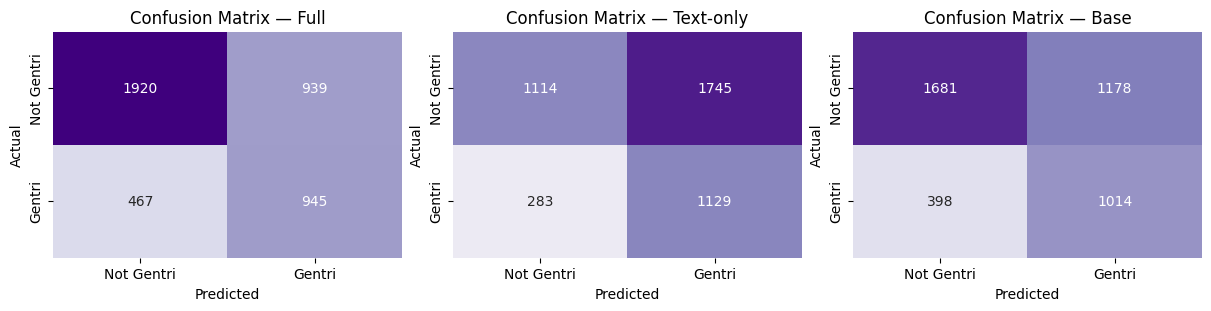

In [129]:
def cv_confusion_matrix(X, y, best_params, n_splits=9, random_state=42):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    total_cm = np.array([[0, 0], [0, 0]])
    #（如果你还想回收统计指标，也可以在这里加同名列表）
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[test_idx]

        # 训练
        clf = XGBClassifier(**best_params)
        clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        # 概率 + F1最优阈值
        proba = clf.predict_proba(X_va)[:, 1]
        prec, rec, ths = precision_recall_curve(y_va, proba)
        f1_curve = 2 * prec * rec / (prec + rec + 1e-12)
        best_idx = f1_curve.argmax()
        thr = ths[max(best_idx - 1, 0)]
        y_pred = (proba >= thr).astype(int)

        total_cm += confusion_matrix(y_va, y_pred)
    return total_cm

# === 三个特征集合 ===
X_features      = final_df[features]
X_feature_text  = final_df[features_text]
X_base          = final_df[base]
y               = final_df['gentrified'].astype(int)

cm_features     = cv_confusion_matrix(X_features, y, best_params)
cm_feature_text = cv_confusion_matrix(X_feature_text, y, best_params)
cm_base         = cv_confusion_matrix(X_base, y, best_params)

# 统一色标，让颜色可比
cm_list = [cm_features, cm_feature_text, cm_base]
vmax_cell = max(m.max() for m in cm_list)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
titles = ['Full', 'Text-only', 'Base']

for ax, cm, title in zip(axes, cm_list, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=['Not Gentri', 'Gentri'],
                yticklabels=['Not Gentri', 'Gentri'],
                cbar=False, vmin=0, vmax=vmax_cell, ax=ax)
    ax.set_title(f'Confusion Matrix — {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.show()

## SHAP值

In [130]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

In [131]:
shap.plots.bar(shap_values, max_display=100)

## 全局特征类型占比贡献图

In [132]:
# 定义类型
feature_types = {'pop_growth_rate': 'Socioeconomic',
                 'avg_den': 'Socioeconomic', 
                 'senior_per': 'Socioeconomic', 
                 'minority_per': 'Socioeconomic',
                 'all_dwelling': 'Socioeconomic',
                 'converted_per': 'Socioeconomic', 
                 'level_4_pop': 'Socioeconomic',
                 'prof_occ_count': 'Socioeconomic',
                 'sale_avg': 'Socioeconomic',
                 'single_per': 'Socioeconomic',
                 'shop_increase': 'Socioeconomic',
                 'bus_increase': 'Socioeconomic',
                 'residential_mean': 'Application', 
                 'commercial_mean': 'Application', 
                 'green_mean': 'Application', 
                 'cultural_mean': 'Application', 
                 'infrustructure_mean': 'Application',
                 'application_count' : 'Socioeconomic',
                 'total_score': 'Application'
}

In [133]:
# 假设 shap_values.values 是 (n_samples, n_features)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# 构造成 DataFrame
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_abs_shap,
    'type': X.columns.map(lambda f: feature_types.get(f, 'Other'))
})

# 按类型聚合

type_avg = shap_df.groupby('type')['mean_abs_shap'].mean()
type_avg_percent = type_avg / type_avg.sum() * 100

type_contrib = shap_df.groupby('type')['mean_abs_shap'].sum()
type_contrib_percent = type_contrib / type_contrib.sum()

In [134]:
type_avg_percent.plot.pie(autopct='%1.1f%%', ylabel='', title='Average SHAP Contribution by Feature Type')

<Axes: title={'center': 'Average SHAP Contribution by Feature Type'}>

<Axes: title={'center': 'SHAP Contribution by Feature Type'}>

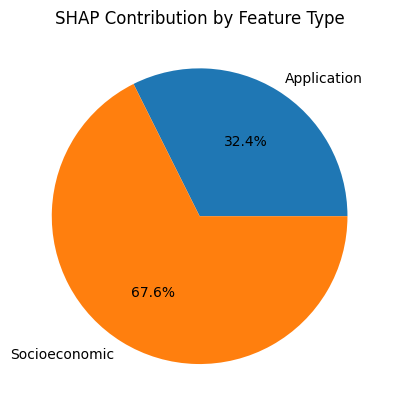

In [135]:
type_contrib_percent.plot.pie(autopct='%1.1f%%', ylabel='', title='SHAP Contribution by Feature Type')

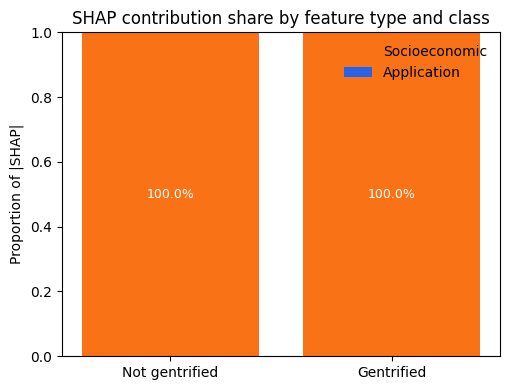

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 输入 ----
# X: 特征DataFrame（列名与SHAP对应）
# y: 0/1 标签（0=Not gentrified, 1=Gentrified）
# shap_values: SHAP 结果，shape=(n_samples, n_features)；若是 shap.Explanation 用 shap_values.values
S = getattr(shap_values, "values", shap_values)  # 兼容两种写法
feature_types = {   # 你的特征分组映射：列名 -> "Application"/"Socioeconomic"
    **{f:"Application"   for f in features},
    **{f:"Socioeconomic" for f in features},
}

# ---- 计算：按类别 × 特征类型 的 |SHAP|占比 ----
types = X.columns.map(lambda f: feature_types.get(f, "Other"))

def shares_by_class(S, y, types, order=("Socioeconomic","Application")):
    out = []
    labels = ["Not gentrified","Gentrified"]
    for cls in [0, 1]:
        S_cls = np.abs(S[y==cls])                     # 该类样本的 |SHAP|
        per_feat = S_cls.sum(axis=0)                 # 避免受样本量影响：对样本取“平均|SHAP|”
        df = pd.DataFrame({"type": types, "val": per_feat})
        bytype = df.groupby("type")["val"].sum().reindex(order, fill_value=0)
        out.append(bytype / bytype.sum())             # 归一化成占比
    res = pd.concat(out, axis=1)
    res.columns = labels
    return res

shares = shares_by_class(S, y.values, types, order=("Socioeconomic","Application"))

# ---- 画图：100% 堆叠柱状图 ----
fig, ax = plt.subplots(figsize=(5.2,4))
x = np.arange(shares.shape[1])
bottom = np.zeros(len(x))

colors = {"Socioeconomic":"#f97316", "Application":"#2563eb"}  # 可自改
for t in shares.index:
    vals = shares.loc[t].values
    ax.bar(x, vals, bottom=bottom, label=t, color=colors.get(t, None))
    # 在每段中间标百分比
    for i, v in enumerate(vals):
        if v > 0.03:
            ax.text(i, bottom[i] + v/2, f"{v*100:.1f}%", ha="center", va="center", color="white", fontsize=9)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(shares.columns)
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion of |SHAP|")
ax.set_title("SHAP contribution share by feature type and class")
ax.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()


In [137]:
# 各类型特征数量
cnt = shap_df.groupby('type')['feature'].count().rename('n_features')
# 各类型总重要性（你已经有了）
total_imp = shap_df.groupby('type')['mean_abs_shap'].sum().rename('total_shap')

check = pd.concat([cnt, total_imp, (total_imp/cnt).rename('avg_shap_per_feature')], axis=1)\
          .sort_values('total_shap', ascending=False)
print(check)

               n_features  total_shap  avg_shap_per_feature
type                                                       
Socioeconomic          10    2.792759              0.279276
Application             6    1.337280              0.222880


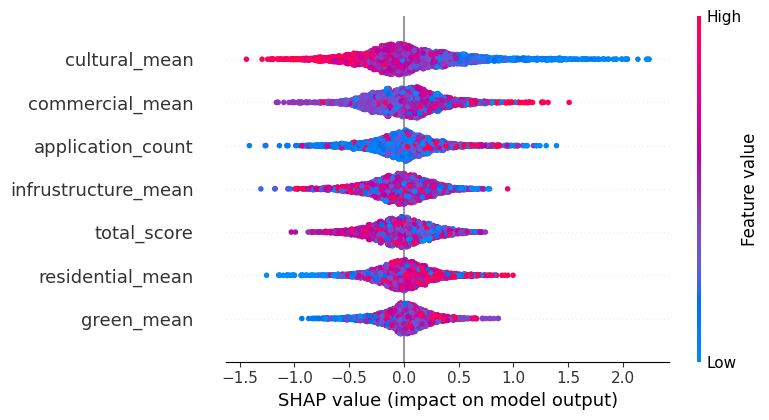

In [138]:
shap.summary_plot(
    shap_values.values[:, [X.columns.get_loc(f) for f in features_text]],
    X[features_text]
)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

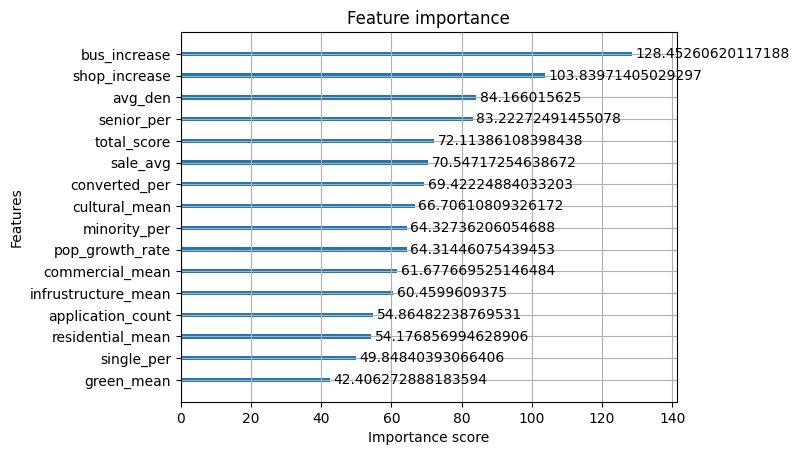

In [139]:
from xgboost import plot_importance
plot_importance(model, importance_type='cover')

## 单个样本SHAP瀑布图

In [140]:
# 随机抽一个非绅士化样本的“单个”索引（不是 Index 对象）
# idx1 = final_df.loc[final_df['gentrified'] == 0].sample(1).index[0]

sample_index = 571

shap_exp = shap.Explanation(
    values=shap_values.values[sample_index],
    base_values=shap_values.base_values[sample_index],
    data=X.iloc[sample_index],
    feature_names=X.columns
)

shap.plots.waterfall(shap_exp, max_display=X.shape[1])  # 显示所有变量


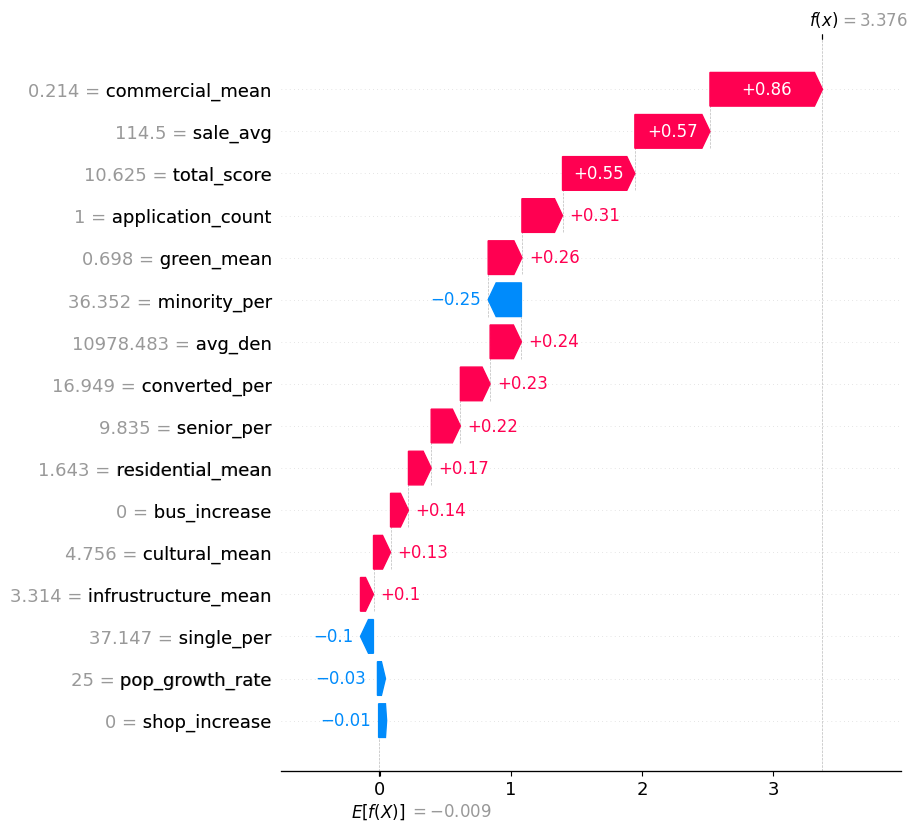

In [141]:
# 随机抽一个非绅士化样本的“单个”索引（不是 Index 对象）
# idx2 = final_df.loc[final_df['gentrified'] == 1].sample(1).index[0]

sample_index = 3917

shap_exp = shap.Explanation(
    values=shap_values.values[sample_index],
    base_values=shap_values.base_values[sample_index],
    data=X.iloc[sample_index],
    feature_names=X.columns
)

shap.plots.waterfall(shap_exp, max_display=X.shape[1])  # 显示所有变量

In [142]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) 取出语义特征的 SHAP 值（正向贡献更能代表“推动绅士化”的语义）
semantic_cols = ['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean']

# shap_values 可为 shap.Explanation 或 ndarray；都转成 DataFrame
shap_df = pd.DataFrame(np.array(shap_values.values), columns=X.columns, index=X.index)
sem_shap = shap_df[semantic_cols]

# 只看正向贡献（负值会被截断为0）
sem_shap_pos = sem_shap.clip(lower=0)

# 每个 LSOA 正向贡献最大的语义类别（若全为0，先置空，后面用“Non-gentrified”覆盖）
dom_semantic = sem_shap_pos.idxmax(axis=1)  # 返回 semantic1~5
no_pos = (sem_shap_pos.max(axis=1) == 0)
dom_semantic[no_pos] = np.nan

# 2) 组合成六类：五个语义类别 + 非绅士化
category = dom_semantic.copy()
category[y == 0] = 'Non-gentrified'   # 统一标第六类
category = category.fillna('Non-gentrified')

# 3) 合并到 LSOA 边界并画图
gdf = gpd.read_file("data/gentri_data/london_gentri_labeled_25_only.shp")  # 你的边界文件
gdf['LSOA code'] = gdf['LSOA code'].astype(str).str.strip()
category.index = category.index.astype(str).str.strip()
plot_df = gdf.merge(category.rename('category'), left_on='LSOA code', right_index=True)


In [143]:
# 把 LSOA code 加到 category
category = pd.Series(category.values, index=final_df['LSOA code'], name='category')
category.index = category.index.astype(str).str.strip()

# 空间数据也统一成字符串
gdf['LSOA code'] = gdf['LSOA code'].astype(str).str.strip()

# 再合并
plot_df = gdf.merge(category, left_on='LSOA code', right_index=True)
print(len(plot_df))  # 应该不为0

4271


In [144]:
plot_df['category']

0            Non-gentrified
1       infrustructure_mean
2            Non-gentrified
3            Non-gentrified
4           commercial_mean
               ...         
4830       residential_mean
4831        commercial_mean
4832         Non-gentrified
4833         Non-gentrified
4834         Non-gentrified
Name: category, Length: 4271, dtype: object

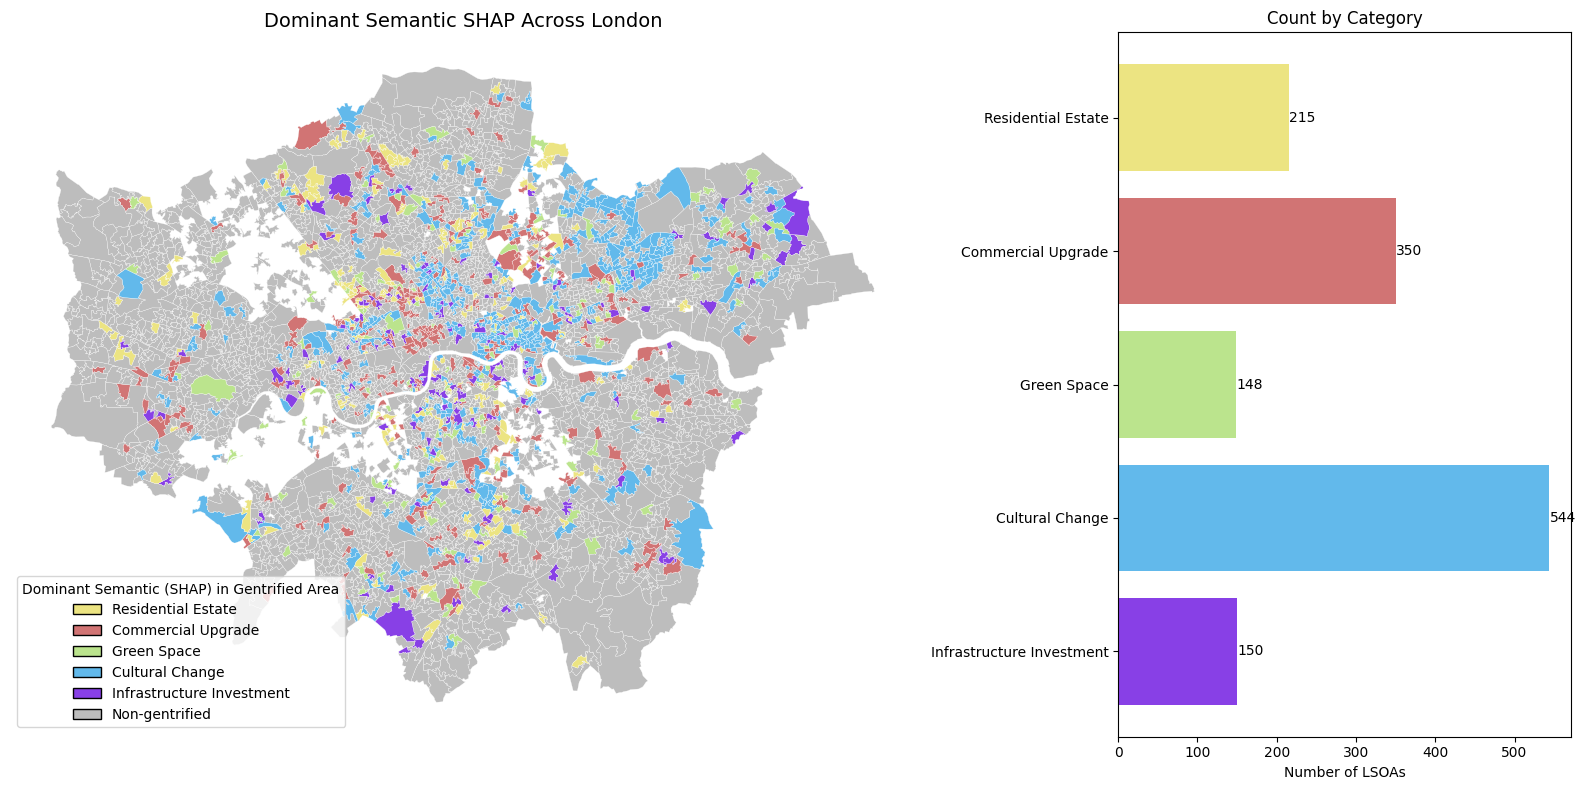

In [145]:
from matplotlib.patches import Patch

order = ['residential_mean', 'commercial_mean', 'green_mean',
         'cultural_mean', 'infrustructure_mean', 'Non-gentrified']

palette = {
    'residential_mean': "#ece482",
    'commercial_mean': "#d17474",
    'green_mean': "#bbe48d",
    'cultural_mean': "#62b9eb",
    'infrustructure_mean': "#8840e6",
    'Non-gentrified': '#bdbdbd'
}

label_map = {
    'residential_mean': 'Residential Estate',
    'commercial_mean': 'Commercial Upgrade',
    'green_mean': 'Green Space',
    'cultural_mean': 'Cultural Change',
    'infrustructure_mean': 'Infrastructure Investment',
    'Non-gentrified': 'Non-gentrified'
}

# 保证顺序和分类类型
plot_df['category'] = pd.Categorical(plot_df['category'], categories=order, ordered=True)
color_series = plot_df['category'].map(palette)

# 统计数量（按顺序）
counts_ordered = plot_df['category'].value_counts(dropna=False).reindex(order, fill_value=0)

# 去掉 Non-gentrified
counts_gentri = counts_ordered.drop('Non-gentrified')

# 创建画布（1行2列）
fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})

# 地图
plot_df.plot(color=color_series, edgecolor='white', linewidth=0.2, ax=ax_map)
ax_map.set_title('Dominant Semantic SHAP Across London', fontsize=14)
ax_map.axis('off')

# 手动图例
present = [k for k in order if (plot_df['category'] == k).any()]
handles = [Patch(facecolor=palette[k], edgecolor='black', label=label_map.get(k, k)) for k in present]
ax_map.legend(handles=handles, title='Dominant Semantic (SHAP) in Gentrified Area',
              loc='lower left', frameon=True, ncol=1)

# 柱状图（右边，不含 Non-gentrified）
ax_bar.barh(range(len(counts_gentri)), counts_gentri, 
            color=[palette[k] for k in counts_gentri.index])

ax_bar.set_yticks(range(len(counts_gentri)))
ax_bar.set_yticklabels([label_map[k] for k in counts_gentri.index])
ax_bar.invert_yaxis()  # 最大值在上
ax_bar.set_xlabel('Number of LSOAs')
ax_bar.set_title('Count by Category')

# 在柱子右侧加数字标注
for i, (count, color) in enumerate(zip(counts_gentri, [palette[k] for k in counts_gentri.index])):
    ax_bar.text(count + 1, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()



In [146]:
print(gdf.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', '2019_final',
       '25_price_g', '25_imd_imp', 'gentrified', 'geometry'],
      dtype='object')


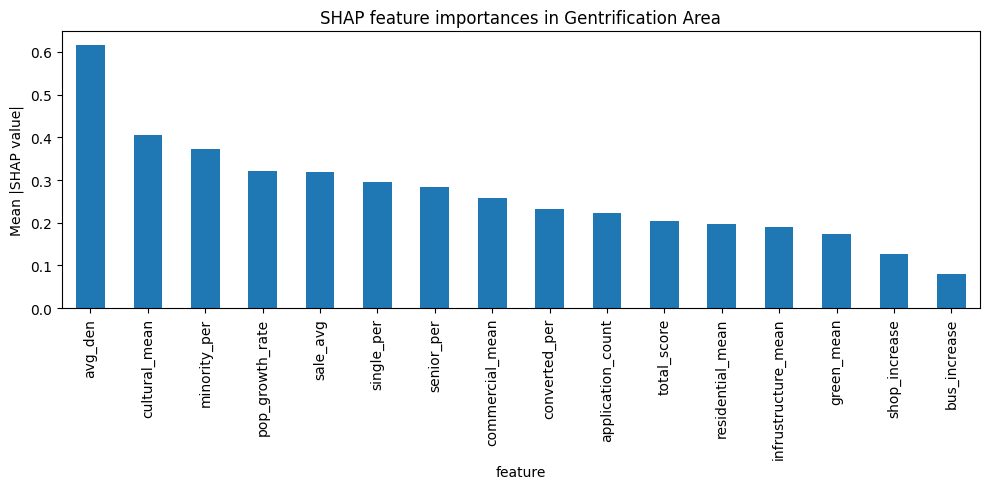

In [147]:
gentri_mask = final_df['gentrified'] == 1

# 假设 gentri_mask 是一个布尔数组，表示哪些样本是 gentri
gentri_shap = shap_values.values[gentri_mask]
gentri_features = final_df[gentri_mask]

# 计算 gentri 样本中每个特征的 mean(|SHAP|) 值
mean_abs_shap = np.abs(gentri_shap).mean(axis=0)

# 变成 dataframe 排序一下
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

# 可视化前 20 个重要特征
shap_df.head(20).plot.bar(x='feature', y='mean_abs_shap', figsize=(10,5), legend=False)
plt.title("SHAP feature importances in Gentrification Area")
plt.ylabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


In [148]:
# 预测值（0/1）
y_pred = model.predict(X)

# 找出预测为 1 的样本
gentrified_mask = y_pred == 1

# 对应的 SHAP 和 X
X_gentri = X[gentrified_mask]
shap_gentri = shap_values.values[gentrified_mask, :]

In [149]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_gentri).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

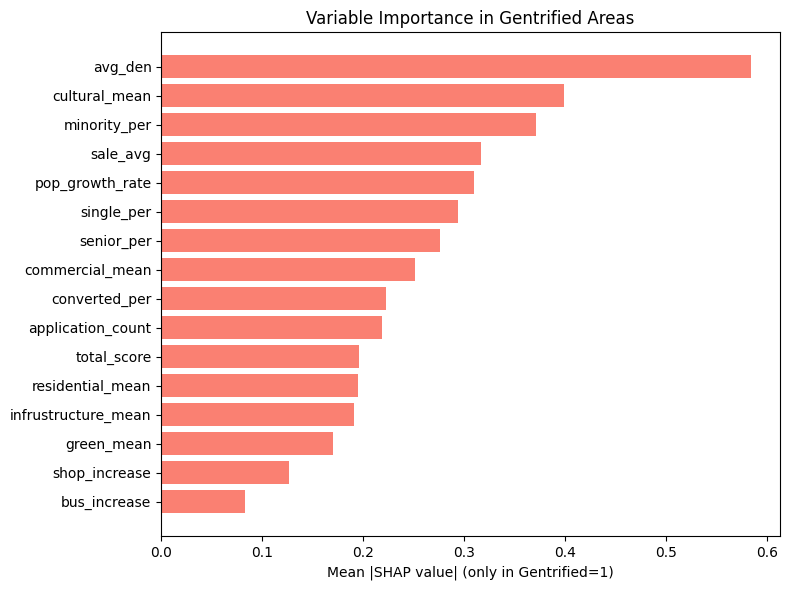

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"], importance_df["mean_abs_shap"], color='salmon')
plt.xlabel("Mean |SHAP value| (only in Gentrified=1)")
plt.title("Variable Importance in Gentrified Areas")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [151]:
signed_mean_shap = shap_gentri.mean(axis=0)

direction_df = pd.DataFrame({
    "feature": X.columns,
    "mean_shap": signed_mean_shap,
    "mean_abs_shap": np.abs(shap_gentri).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

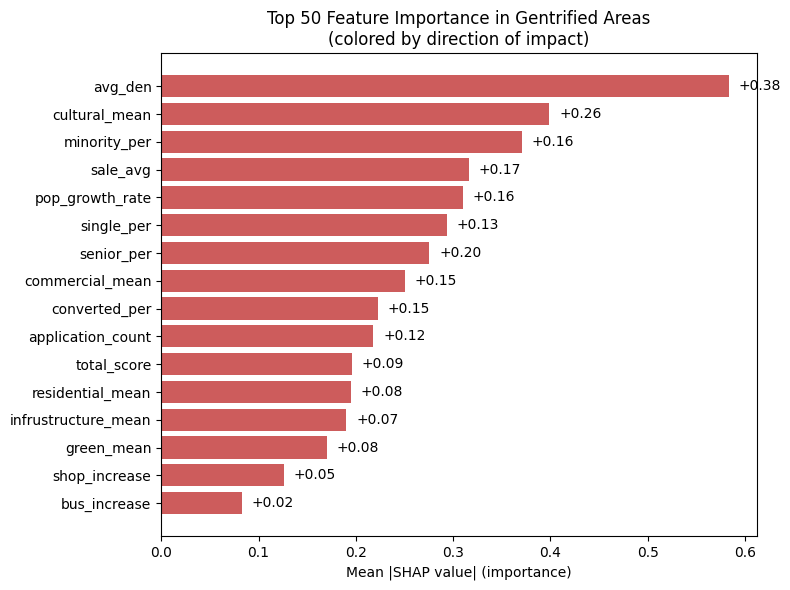

In [152]:
# 取前 N 个变量
top_n = 50
df_plot = direction_df.head(top_n).copy()

# 设置颜色：正向为红，负向为蓝
colors = df_plot["mean_shap"].apply(lambda x: 'indianred' if x > 0 else 'steelblue')

plt.figure(figsize=(8, 6))
bars = plt.barh(
    df_plot["feature"], 
    df_plot["mean_abs_shap"], 
    color=colors
)

plt.xlabel("Mean |SHAP value| (importance)")
plt.title(f"Top {top_n} Feature Importance in Gentrified Areas\n(colored by direction of impact)")
plt.gca().invert_yaxis()  # 让重要的特征在上方

# 添加数值标签
for i, (shap_val, bar) in enumerate(zip(df_plot["mean_shap"], bars)):
    direction = f"+{shap_val:.2f}" if shap_val > 0 else f"{shap_val:.2f}"
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, direction, va='center')

plt.tight_layout()
plt.show()
